In [1]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
print("tf version {0} executing eagerly is {1}".format(tf.__version__, tf.executing_eagerly()))

import tensorflow_probability as tfp
print("tfp version {0}".format(tfp.__version__))

TensorFlow 2.x selected.
tf version 2.1.0 executing eagerly is True
tfp version 0.9.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/StoicNetData/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device_name = tf.test.gpu_device_name()
print("Device name: \"{0}\"".format(device_name))
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Device name: "/device:GPU:0"
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import sys
import os
import time
import numpy as np
import glob
import PIL
import imageio
import matplotlib.pyplot as plt
from IPython import display

import warnings
warnings.simplefilter('error', UserWarning)
warnings.filterwarnings("error")

In [0]:
tf.random.set_seed(98475651423)

In [0]:
IMG_HEIGHT = 112
IMG_WIDTH = 112

keys_to_features = {
    'image_neutral': tf.io.FixedLenFeature([], tf.string),
    'image_expressive': tf.io.FixedLenFeature([], tf.string),
    'image_other': tf.io.FixedLenFeature([], tf.string)
}

def parser(record):
    parsed = tf.io.parse_single_example(record, keys_to_features)
    
    imageNeutral = tf.io.decode_raw(parsed["image_neutral"], tf.uint8)
    imageExpressive = tf.io.decode_raw(parsed["image_expressive"], tf.uint8)
    imageOther = tf.io.decode_raw(parsed["image_other"], tf.uint8)
    
    imageNeutral = tf.cast(imageNeutral, tf.float32)
    imageExpressive = tf.cast(imageExpressive, tf.float32)
    imageOther = tf.cast(imageOther, tf.float32)
    
    imageNeutral = tf.reshape(imageNeutral, shape=[224,224,1])
    imageExpressive = tf.reshape(imageExpressive, shape=[224,224,1])
    imageOther = tf.reshape(imageOther, shape=[224,224,1])

    imageNeutral = tf.image.resize(imageNeutral, size=[IMG_HEIGHT,IMG_WIDTH])
    imageExpressive = tf.image.resize(imageExpressive, size=[IMG_HEIGHT,IMG_WIDTH])
    imageOther = tf.image.resize(imageOther, size=[IMG_HEIGHT,IMG_WIDTH])

    imageNeutral /= (255/2)
    imageExpressive /= (255/2)
    imageOther /= (255/2)
    imageNeutral -= 1
    imageExpressive -= 1
    imageOther -= 1

    return {"imageNeutral":imageNeutral, "imageExpressive":imageExpressive, "imageOther":imageOther}

In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

DB_PATH = BASE_DIR
raw_train = tf.data.TFRecordDataset(DB_PATH + "train.tfrecords")
raw_test = tf.data.TFRecordDataset(DB_PATH + "test.tfrecords")

#raw_val = raw_test.shard(2,0)
#raw_test = raw_test.shard(2,1)

parsed_train = raw_train.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#parsed_val = raw_val.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
parsed_test = raw_test.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

latent_dim = 100

In [8]:
class Recognizer(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Recognizer, self).__init__()
        self.encoder = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
 
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim)
        ], name="encoder")

        self.comparer = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ], name="comparer")

    
    @tf.function
    def recognize(self, a, b):
        a_encoding = self.encode(a)
        b_encoding = self.encode(b)

        return self.decide(a_encoding, b_encoding)
    
    @tf.function
    def encode(self, x):
        encoding = self.encoder(x)
        return encoding

    @tf.function
    def decide(self, a_enc, b_enc):
        diffs = tf.abs(a_enc - b_enc)
        prediction = self.comparer(diffs)
        return prediction

recognizer = Recognizer(latent_dim)
recognizer.load_weights(BASE_DIR + 'saved_model/recognizerWeights')

In [0]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim), # no activation...
        ], name="encoder")

        self.generator = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),

            tf.keras.layers.Dense(units=7*7*256),
            tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=4, strides=(2, 2), padding="SAME", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=False,
                activation="tanh"),
        ], name="generator")

    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    @tf.function
    def sample(self, epsilon=None):
        if epsilon is None:
            epsilon = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(epsilon, apply_sigmoid=True)
    
    @tf.function
    def reparameterize(self, mean, logvar):
        # Logvar used for numerical stability
        epsilon = tf.random.normal(shape=mean.shape)
        return epsilon * tf.exp(logvar * .5) + mean

    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.generator(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    @tf.function
    def generateDist(self, mean, logvar):
        z = self.reparameterize(mean, logvar)
        return self.generateZ(z)

    @tf.function
    def generateZ(self, z):
        x_logit = self.decode(z)
        return x_logit

In [0]:
@tf.function
def generateImg(x):
    mean, logvar = vae.encode(x)
    return vae.generateDist(mean, logvar)

In [0]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Dense(1, activation='sigmoid'),
        ], name="discriminator")
    
    @tf.function
    def decide(self, x):
        return self.discriminator(x)


In [0]:
vae_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam( learning_rate=0.0001, beta_1=0.5)

prior = tfp.distributions.MultivariateNormalDiag(tf.zeros(latent_dim), tf.ones(latent_dim))

@tf.function
def compute_apply_gradients(vae, dis, x_neutral, x_express, x_other, vaeOptimizer, disOptimizer, alpha, beta):
    # Watch any trainable variables for automatic differentiation
    with tf.GradientTape(persistent=True) as tape:
        vloss, dloss = compute_loss(vae, dis, x_neutral, x_express, x_other, alpha, beta)

    gradients_of_vae = tape.gradient(vloss, vae.trainable_variables)
    gradients_of_discriminator = tape.gradient(dloss, dis.trainable_variables)
    vaeOptimizer.apply_gradients(zip(gradients_of_vae, vae.trainable_variables))
    disOptimizer.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))


@tf.function
def compute_loss(vae, dis, x_neutral, x_express, x_other, alpha, beta):
    mean_e, logvar_e = vae.encode(x_express)
    if beta < 0.5:
        # Just be an auto-encoder to warm up
        generated_images = vae.generateZ(mean_e)
    else:
        # Now let's get variational up in here
        generated_images = vae.generateDist(mean_e, logvar_e)
    
    # Let the discriminator discriminate
    real_decisions = dis.decide(x_neutral)
    fake_decisions = dis.decide(generated_images)

    # Compute all the losses
    dloss = discriminator_loss(real_decisions, fake_decisions)
    vloss = vae_loss(x_express, generated_images, fake_decisions, mean_e, logvar_e, alpha, beta)
    return vloss, dloss


@tf.function
def compute_ALL_loss(vae, dis, x_neutral, x_express, x_other, alpha, beta):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    mean_e, logvar_e = vae.encode(x_express)
    if beta < 0.5:
        # Just be an auto-encoder to warm up
        generated_images = vae.generateZ(mean_e)
    else:
        # Now let's get variational up in here
        generated_images = vae.generateDist(mean_e, logvar_e)
    
    # Let the discriminator discriminate
    real_decisions = dis.decide(x_neutral)
    fake_decisions = dis.decide(generated_images)


    # Loss from failing to identify real images
    real_labels = tf.ones_like(real_decisions)
    real_loss = cross_entropy(real_labels, real_decisions)
    
    # Loss from failing to identify fake images
    fake_labels = tf.zeros_like(fake_decisions)
    fake_loss = cross_entropy(fake_labels, fake_decisions)
    
    # RealLoss + FakeLoss
    dloss = tf.math.add(real_loss, fake_loss)


    # Loss from not preserving identity (weighted by alpha)
    identityScores = recognizer.recognize(x_express, generated_images)
    identityLoss = cross_entropy(tf.ones_like(identityScores), identityScores)
    identityLoss = tf.math.multiply(alpha, identityLoss)

    # Loss from not fooling the discriminator
    detectionLoss = cross_entropy(tf.ones_like(fake_decisions), fake_decisions)

    # KL Divergence Loss (weighted by beta)
    posterior = tfp.distributions.MultivariateNormalDiag(mean_e, logvar_e)
    divergenceLoss = tfp.distributions.kl_divergence(posterior, prior)
    divergenceLoss = tf.math.multiply(beta, divergenceLoss)

    # IdentityLoss + DetectionLoss + DivergenceLoss)
    return identityLoss, detectionLoss, divergenceLoss, dloss


@tf.function
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    # Loss from failing to identify real images
    real_labels = tf.math.subtract(tf.ones_like(real_output), tf.random.uniform(real_output.shape, minval=0, maxval=0.1))
    real_loss = cross_entropy(real_labels, real_output)
    
    # Loss from failing to identify fake images
    fake_labels = tf.math.add(tf.zeros_like(fake_output), tf.random.uniform(fake_output.shape, minval=0, maxval=0.1))
    fake_loss = cross_entropy(fake_labels, fake_output)
    
    # RealLoss + FakeLoss
    return tf.math.add(real_loss, fake_loss)


@tf.function
def vae_loss(x_express, output_images, output_decisions, mean_e, logvar_e, alpha, beta):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    # Loss from not preserving identity (weighted by alpha)
    identityScores = recognizer.recognize(x_express, output_images)
    identityLoss = cross_entropy(tf.ones_like(identityScores), identityScores)
    identityLoss = tf.math.multiply(alpha, identityLoss)

    # Loss from not fooling the discriminator
    detectionLoss = cross_entropy(tf.ones_like(output_decisions), output_decisions)

    # KL Divergence Loss (weighted by beta)
    posterior = tfp.distributions.MultivariateNormalDiag(mean_e, logvar_e)
    divergenceLoss = tf.reduce_mean(tfp.distributions.kl_divergence(posterior, prior))
    divergenceLoss = tf.math.multiply(beta, divergenceLoss)

    # IdentityLoss + DetectionLoss + DivergenceLoss
    return tf.math.add(tf.math.add(identityLoss, detectionLoss), divergenceLoss)


In [0]:
epochs = 200
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
random_images_for_generation = [image_features['imageExpressive'] for image_features in parsed_test.take(1)][0][0:num_examples_to_generate]

vae = VAE(100)
discriminator = Discriminator()

In [0]:
# setup checkpoint stuff
checkpoint_dir = BASE_DIR + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(vae_optimizer=vae_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 vae=vae,
                                 discriminator=discriminator)

In [0]:
def save_images(epoch, test_input):
    imgs = vae.sample(test_input)
    assert not np.any(np.isnan(imgs))
    fig = plt.figure(figsize=(4,4))
    ds = discriminator.decide(imgs)
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.gca().set_title("{0:.4f}".format(ds[i,0]))
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

def display_discrim_images(imgs, dis):
    fig = plt.figure(figsize=(4,4))
    ds = discriminator.decide(imgs)
    for i in range(imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.gca().set_title("{0:.4f}".format(ds[i,0]))
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.show()

def display_imgs_ratings(test_input, epoch=-1):
    images = generateImg(test_input[0:8])
    rs = recognizer.recognize(test_input[0:8], images)
    ims = np.concatenate((test_input[0:8], images), axis=0)
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(11,4))
    ds = discriminator.decide(ims)
    for i in range(ims.shape[0]):
        c = i % 8
        r = i // 8
        if r == 1:
            axes[r, c].set_title("d {0:.6f}\nr {1:.4f}".format(ds[i,0], rs[c,0]))
        else: 
            axes[r, c].set_title("d {0:.6f}".format(ds[i,0]))
        axes[r, c].imshow(ims[i, :, :, 0], cmap='gray')
        axes[r, c].set_yticklabels([])
        axes[r, c].xaxis.set_visible(False)
    axes[0,0].set_ylabel("Inputs", size='large')
    axes[1,0].set_ylabel("Generated", size='large')
    fig.tight_layout()
    if epoch >= 0:
        plt.savefig('gens_ratings_at_epoch_{:04d}.png'.format(epoch))
        plt.close(fig)
    else:
        plt.show()

def plot_GAN_loss(ls):
    vl, dl = zip(*ls)
    fig = plt.figure()
    plt.plot(vl, 'g', label='Lv')
    plt.plot(dl, 'r', label='Ld')
    plt.title("VAE (Lv) and Discriminator (Ld) Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_ALL_loss(ls):
    il, fl, kl, dl = zip(*ls)
    fig = plt.figure()
    plt.plot(il, '-og', label='Lv_i')
    plt.plot(fl, '-oy', label='Lv_f')
    plt.plot(kl, '-ob', label='Lv_k')
    plt.plot(dl, '-or', label='Ld')
    plt.title("VAE (Lv) and Discriminator (Ld) Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

Epoch 5, VAE Loss (0.0, 2.2481513, 0.30378455), Disc Loss 0.6165225505828857, Total epoch time 82.9
Alpha: 0.000, Beta: 0.250


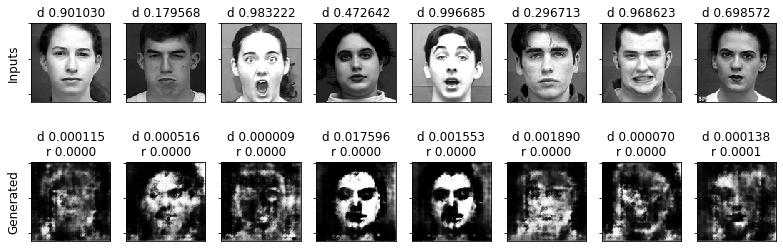

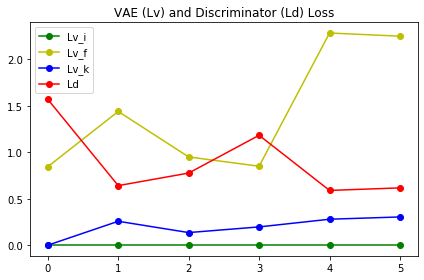


Training...........................

In [0]:
# Save image for pre-training
max_alpha = 1.0
alpha = 0.0
alpha_ramp_start = 10
alpha_ramp_end = 30
max_beta = 1.0
beta = 0.0
beta_ramp_end = 20

ls = []
start_time = end_time = 0
for epoch in range(0, epochs):

    # Train
    print("\nTraining", end="")
    start_time = time.time()
    batchCounter = 0
    alpha = min(max_alpha, max_alpha * (max(0,(epoch - alpha_ramp_start)) / alpha_ramp_end))
    alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
    beta = min(max_beta, max_beta * (epoch / beta_ramp_end))
    beta = tf.convert_to_tensor(beta, dtype=tf.float32)
    for image_features in parsed_train:
        neutral_raw = image_features['imageNeutral']
        assert not np.any(np.isnan(neutral_raw))
        expressive_raw = image_features['imageExpressive']
        assert not np.any(np.isnan(expressive_raw))
        other_raw = image_features['imageOther']
        assert not np.any(np.isnan(other_raw))

        compute_apply_gradients(
            vae, discriminator,
            neutral_raw, expressive_raw, other_raw,
            vae_optimizer, discriminator_optimizer,
            alpha, beta)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")
    
    # Test
    print("\nTesting", end="")
    batchCounter = 0
    iloss = tf.keras.metrics.Mean()
    floss = tf.keras.metrics.Mean()
    kloss = tf.keras.metrics.Mean()
    dloss = tf.keras.metrics.Mean()
    for image_features in parsed_test:
        neutral_raw = image_features['imageNeutral']
        expressive_raw = image_features['imageExpressive']
        other_raw = image_features['imageOther']

        il, fl, kl, dl = compute_ALL_loss(vae, discriminator,
                                          neutral_raw, expressive_raw, other_raw,
                                          alpha, beta)
        iloss(il)
        floss(fl)
        kloss(kl)
        dloss(dl)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")

    il = iloss.result().numpy()
    fl = floss.result().numpy()
    if epoch == 0 and fl > 2.0:
        fl = 2.0
    kl = kloss.result().numpy()
    dl = dloss.result().numpy()
    ls = ls + [(il, fl, kl, dl)]
    
    end_time = time.time()

    # Output
    display.clear_output(wait=False)
    print('Epoch {0}, VAE Loss {1}, Disc Loss {2}, '
        'Total epoch time {3:.1f}'.format(
            epoch, (il, fl, kl), dl, end_time - start_time))
    print("Alpha: {0:.3f}, Beta: {1:.3f}".format(alpha, beta))
    display_imgs_ratings(random_images_for_generation)    
    save_images(epoch, random_vector_for_generation)
    plot_ALL_loss(ls)

    # Save the model from time to time
    if (epoch + 1) % 20 == 0:
        display_imgs_ratings(random_images_for_generation, epoch)
        checkpoint.save(file_prefix = checkpoint_prefix)

    tf.keras.backend.clear_session()

In [0]:
checkpoint_prefix = os.path.join(checkpoint_dir, "FINAL_CKPT_" + time.strftime('%l:%M%b%d'))
checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
anim_filename = BASE_DIR + 'TrainingGifs/vaegan' + time.strftime('%l:%M %b %d') + '.gif'
print(anim_filename)
with imageio.get_writer(anim_filename, mode='I') as writer:
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [0]:
plot_GAN_loss(ls)